# 一次元畳み込みニューラルネットワークの実装

In [4]:
import numpy as np
import pandas as pd

from keras.datasets import mnist

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

## まず適当なテストデータを作る
1dCNNは多くの場合で時系列解析に用いられます。そのため、テストデータは簡単な異常検知モデルにしてみましょう。

※本来、時系列の異常検知システムは逐次的に見ることが多いので、本当はこんな風にバッチごとに見るようなことは少ないです。

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 1, 784)
X_test = X_test.reshape(-1, 1, 784)

print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 1, 784)
(10000, 1, 784)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
  247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
  170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
    0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
   82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253


In [7]:
X_train = X_train.reshape(-1, 1, 784)
X_test = X_test.reshape(-1, 1, 784)

In [8]:
X_train = X_train[:2400]
y_train = y_train[:2400]
X_test = X_test[:600]
y_test = y_test[:600]

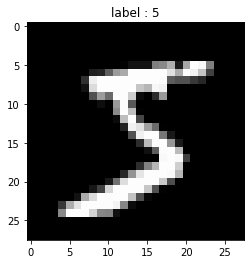

In [9]:
index = 0
image = X_train[index].reshape(28,28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [10]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

print(X_train.shape, y_train.shape) # (48000, 784)
print(X_val.shape, y_val.shape) # (12000, 784)

1.0
0.0
(2400,)
(2400, 10)
float64
(1920, 1, 784) (1920, 10)
(480, 1, 784) (480, 10)


### 【問題2】1次元畳み込み後の出力サイズの計算

$$
N_{out} = \frac{N_{in}+2P-F}{S}+1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ



In [ ]:
def calc_out_shape(N_in, P, F, S):
    N_out = ((N_in + 2 * P - F) / S) + 1
    return int(N_out)

In [ ]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
padding=0
stride = 1

calc_out_shape(4, padding, len(w), stride)

2

### 【問題１】チャンネル数の1に限定した一次元畳み込み層のクラスの作成

一次元畳み込み層のクラスを作成しましょう。DNNの時と同じような設計になるように、見比べながらやるといいです。

In [11]:
class Scratch1dCNNClassifier:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self):       
        self.W = np.array([3,5,7]) 
        self.B = np.array([1])
        self.padding = 0
        self.strides = 1        
        self.filters = len(self.W)
        self.a = np.array([])
        self.dW = np.array([])
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes_bf)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_af)
            出力
        """
        self.X = X
        self.N_in = len(self.X)
        self.N_out = int((self.N_in + 2*self.padding - self.filters) / self.strides + 1) # 出力サイズの計算
        
        self.a = np.append(self.a, [np.dot(self.X[i : i+self.filters], self.W) + self.B for i in range(self.N_out)])

        return self.a
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = np.sum(dA, axis=0)        
        self.dW = np.append(self.dW, [np.dot(self.X[i : i+self.N_out].T, dA) for i in range(self.filters)])


        self.dX = np.zeros(len(self.X))            
        for j in range(len(self.X)):
            for s in range(len(self.W)):
                if j - s < 0 or j - s > 1:
                    self.dX[j] = self.dX[j]
                else:
                    self.dX[j] = self.dX[j] + dA[j - s] * self.W[s]

        return self.dX

### 【問題3】小さな配列での1次元畳み込み層の実験

フォワードプロパゲーションでは入力とパラメータが以下のようになっているとき

In [13]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

In [14]:
model = Scratch1dCNNClassifier()
model.forward(x)

array([35., 50.])

出力はこうなっているはずです
```python
a = np.array([35, 50])
```

バックプロパゲーションで誤差が以下のようなとき

In [15]:
delta_a = np.array([10, 20])
model.backward(delta_a)

array([ 30., 110., 170., 140.])

```python
delta_b = np.array([30])
delta_w = np.array([50, 80, 110])
delta_x = np.array([30, 110, 170, 140])
```
と、このようになります。

### 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

In [16]:
class Conv1d:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self):       
        self.W = np.ones((3, 2, 3)) 
        self.B = np.array([1, 2, 3])
        self.padding = 0
        self.strides = 1        
        self.filters = self.W.shape[2]        
        #self.a = np.array([])
        #self.dW = np.array([])
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes_bf)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_af)
            出力
        """
        self.X = X
        self.N_in = self.X.shape[1]
        self.N_out = int((self.N_in + 2*self.padding - self.filters) / self.strides + 1) # 出力サイズの計算

        self.a = np.zeros((self.W.shape[0], self.N_out)) #出力チャネル数、出力サイズ
        for i in range(self.W.shape[0]): #出力チャネル
            for j in range(self.X.shape[0]): #入力チャネル
                for s in range(self.N_out): #出力サイズ
                    self.a[i, j] = self.a[i, j] + np.dot(self.X[j, s: s+self.filters], self.W[i, j])
                    
        #バイアス
        self.a = self.a + self.B.reshape(-1, 1)

        return self.a
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = np.sum(dA, axis=1)
        
        self.dW = np.zeros((self.W.shape[0], self.X.shape[0], self.filters)) #出力チャネル数、出力サイズ、フィルタサイズ
        for i in range(self.W.shape[0]): #出力チャネル
            for j in range(self.X.shape[0]): #入力チャネル
                for s in range(self.filters): #フィルタサイズ
                        self.dW[i, j, s] = np.dot(self.X[j][s : s+self.N_out].T, dA[s])

        self.dX = np.zeros(self.X.shape)
        for i in range(self.W.shape[0]): #出力チャネル
            for j in range(self.X.shape[0]): #入力チャネル
                for s in range(self.filters): #フィルタサイズ
                    for n in range(self.N_out): #出力サイズ
                        self.dX[j, s + n] = self.dX[j, s + n] + dA[i, n] * self.W[i, j, s]

        return self.dX

問題３と同じく出力を確認しましょう。

フォワードプロパゲーションでは入力とパラメータが以下のようになっているとき

In [17]:
model = Conv1d()
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

In [19]:
model.forward(x)

array([[16., 22.],
       [17., 23.],
       [18., 24.]])

```python
a = np.array([[16, 22], [17, 23], [18, 24]])
```

となっていれば正解です。

In [21]:
delta_a = np.array([[10, 20], [10, 20], [10, 20]])
model.backward(delta_a)

array([[30., 90., 90., 60.],
       [30., 90., 90., 60.]])

### 【問題8】学習と推定

これまでと同じように、活性化関数やOptimizerのクラス（関数）を組み合わせて学習・推定させましょう。
チャンネル数が１よりも大きいときはうまく実行できません。なので、**平滑化**を行えるクラス（関数）を作りましょう。
発展的にGlobal Average Pollingを実装しても問題ありません。

In [24]:
class Flatten():
    def __init__(self):
        self.X_shape = None
    
    def forward(self, X):
        # 1次元化
        X_1d = X.reshape(X.shape[0], -1)
        
        # shapeの記録
        self.X_shape = X.shape
        
        return X_1d    

    def backward(self, X):
        # shapeの返戻
        X = X.reshape(self.X_shape)
        
        return X

DNNの時と同じようにモデル全体を作っていきましょう。
まずは上に用意したデータなどで試して見てください。

In [25]:
class Scratch1dCNNClassifier:
    """
    ディープニューラルネットワーク分類器

    Parameters
    --------------
    activaiton : {'sigmoid', 'tanh', 'relu'} 
        活性化関数の種類
    n_nodes : list
        ノードの構成 例 [400, 200, 100]
    n_output : int
        出力層の数
    alpha : float
        学習率
    optimizer :  {'sgd', 'adagrad'}
        最適化手法の種類
    filter_num : int
        フィルタ数
    filter_size : int
        フィルタサイズ
        
    Attributes
    -------------
    FC[n_layers] :  dict
        結合層を管理する辞書
    activation : dict
        活性化関数を管理する辞書
    self.epochs : int
        エポック数(初期値：10)
    self.batch_size : int
        バッチサイズ(初期値：20)
    self.n_features : int
        特徴量の数
    self.val_is_true : boolean
        検証用データの有無    
    self.loss : 空のndarray
        訓練データに対する損失の記録
    self.loss_val : 空のndarray
        検証データに対する損失の記録
        
    """    
    def __init__(self, activation, n_nodes, n_output, lr, optimizer, filter_num, filter_size):
        self.select_activation = activation
        self.n_nodes = n_nodes
        self.n_output = n_output
        self.lr = lr
        self.select_optimizer = optimizer
        
        # Sprint11 追加*******************************
        self.filter_num  = filter_num                         # フィルタ数
        self.filter_size   = filter_size    # フィルタサイズ
        # Sprint11 追加*******************************
            
    def __initialize_n_layers(self):
        """
        N層を初期化する。
        sigmoid関数とtanh関数が活性化関数の場合：Xavierを初期値
        ReLU関数が活性化関数の場合：Heを初期値
        """
        self.activation = dict()
        self.FC = dict()
        # Sprint11 追加*********************************************************************
        #n_nodes = self.out // (2**(1))
        if self.select_activation == 'sigmoid':
            self.FC[0] = FC(self.out, self.n_nodes[0], 
                            XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = Sigmoid()
        elif self.select_activation == 'tanh':
            self.FC[0] = FC(self.out, self.n_nodes[0], 
                            XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = Tanh()
        elif self.select_activation == 'relu':
            self.FC[0] = FC(self.out, self.n_nodes[0], 
                            HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = ReLU()
        # Sprint11 追加*********************************************************************

        for n_layer in range(len(self.n_nodes)):            
            if n_layer == len(self.n_nodes) -1:
                if self.select_activation == 'sigmoid':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output, 
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
                elif self.select_activation == 'tanh':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output,
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
                elif self.select_activation == 'relu':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output,
                                              HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
            else:
                if self.select_activation == 'sigmoid':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1], 
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Sigmoid()
                elif self.select_activation == 'tanh':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1],
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Tanh()
                elif self.select_activation == 'relu':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1],
                                              HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = ReLU()
    
    def fit(self, X, y, epochs=10, batch_size=20):  
        self.epochs = epochs                            # エポック数     
        self.batch_size = batch_size               # バッチサイズ
        self.loss = np.zeros(self.epochs)        # 学習曲線・目的関数の出力用(訓練データ)
        self.loss_val = np.zeros(self.epochs) # 学習曲線・目的関数の出力用(検証データ)        
        
        if self.select_optimizer == 'sgd':
            self.optimizer = SGD(self.lr)
        elif self.select_optimizer == 'adagrad':
            self.optimizer = AdaGrad(self.lr)            
        
        # Sprint11 追加*********************************************************************
        # 畳み込み層クラス
        self.input_channel = X.shape[1]
        self.input_feature = X.shape[2]
        
        self.conv1d = Conv1d(self.select_activation, self.optimizer, self.filter_num, self.input_channel, self.filter_size)
        if self.select_activation == 'sigmoid':
            self.activation_conv = Sigmoid()
        elif self.select_activation == 'tanh':
            self.activation_conv = Tanh()
        elif self.select_activation == 'relu':
            self.activation_conv = ReLU()
 
        #ミニバッチの取得
        get_mini_batch = GetMiniBatch(X, y, self.batch_size)

        # 平滑化クラス
        self.flatten = Flatten()
        self.out = self.filter_num * (self.input_feature - (self.filter_size - 1))
        # Sprint11 追加*********************************************************************        
        
        self.__initialize_n_layers()
        
        for epoch in range(self.epochs):
            #get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size) # Sprint11 削除
            print("epoch ", epoch + 1 , " processing . . .")
            for mini_X_train,  mini_y_train in get_mini_batch:
                self.X_ = mini_X_train
                self.y_ = mini_y_train
                
                # フォワードプロバゲーション
                # Sprint11 追加*********************************************************************
                #畳み込み(1層目)
                self.A = self.conv1d.forward(self.X_) 
                self.Z = self.activation_conv.forward(self.A)    
                
                #平滑化
                self.F = self.flatten.forward(self.Z)
                               
                self.A = self.FC[0].forward(self.F)
                self.Z = self.activation[0].forward(self.A)                         
                
                # Sprint11 追加*********************************************************************
                
                self.A = self.FC[1].forward(self.Z)            #1層目
                self.Z = self.activation[1].forward(self.A) #1層目
                for n_layer in range(2, len(self.n_nodes) + 1): #2層目以降
                    self.A = self.FC[n_layer].forward(self.Z)
                    self.Z = self.activation[n_layer].forward(self.A)
                
                # バックプロパゲーション
                self.dA, self.loss[epoch] = self.activation[len(self.n_nodes)].backward(self.Z, self.y_) #最終層, 交差エントロピー誤差
                self.dZ = self.FC[len(self.n_nodes)].backward(self.dA) #最終層           
                for n_layer in reversed(range(0, len(self.n_nodes))): #最終層 - 1
                    self.dA = self.activation[n_layer].backward(self.dZ)
                    self.dZ = self.FC[n_layer].backward(self.dA)

                # Sprint11 追加********************************
                # shapeの戻入
                self.dF = self.flatten.backward(self.dZ)
                
                # 畳み込み層
                self.dA = self.activation_conv.backward(self.dF)
                self.dZ = self.conv1d.backward(self.dA)
                # Sprint11 追加********************************
                
    def predict(self,X):
        
        # Sprint11 追加********************************
        #畳み込み(1層目)
        self.A = self.conv1d.forward(X) 
        self.Z = self.activation_conv.forward(self.A)    

        #平滑化
        self.F = self.flatten.forward(self.Z)

        self.A = self.FC[0].forward(self.F)            #1層目
        self.Z = self.activation[0].forward(self.A) #1層目
        # Sprint11 追加********************************
        
        # フォワードプロバゲーション
        self.A = self.FC[1].forward(self.Z)                     #1層目
        self.Z = self.activation[1].forward(self.A) #1層目
        for n_layer in range(2, len(self.n_nodes) + 1): #2層目以降
            self.A = self.FC[n_layer].forward(self.Z)
            self.Z = self.activation[n_layer].forward(self.A)
        
        return np.argmax(self.Z, axis=1)

In [26]:
class Conv1d:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, activation, optimizer, filter_num, input_channel, filter_size):
        self.activation = activation
        self.optimizer = optimizer
        self.filter_num = filter_num
        self.input_channel = input_channel
        self.filter_size = filter_size
        self.pad = 0
        self.stride = 1
        
        if self.activation == 'sigmoid':
            initializer = XavierInitializer(self.filter_num, self.input_channel, self.filter_size)
            self.W = initializer.W(_, _)
            self.B = initializer.B(_)            
        elif self.activation == 'tanh':
            initializer = XavierInitializer(self.filter_num, self.input_channel, self.filter_size)
            self.W = initializer.W(_, _)
            self.B = initializer.B(_)          
        elif self.activation == 'relu':
            initializer = HeInitializer(self.filter_num, self.input_channel, self.filter_size)
            self.W = initializer.W(_, _)
            self.B = initializer.B(_)

        self.X = None
        self.N_in = None
        self.N_out = None
        self.a = None
        self.dB = None
        self.dW = None
        self.dX = None
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes_bf)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_af)
            出力
        """
        self.X = X
        
        #shapeの取得
        batch_size, input_channel, self.N_in = self.X.shape #(バッチサイズ, 入力チャンネル, 特徴量)
        FN, C, FS = self.W.shape #(出力チャンネル,  入力チャンネル, フィルタサイズ)
        
        self.N_out = int((self.N_in + 2*self.pad - self.filter_size) / self.stride + 1) # 出力サイズの計算

        self.a = np.zeros((batch_size, FN, self.N_out)) #バッチサイズ、出力チャネル数、出力サイズ
        for b in range(batch_size): # バッチサイズ
            for i in range(FN): #出力チャネル
                for j in range(C): #入力チャネル
                    for s in range(self.N_out): #出力サイズ
                        self.a[b, i, s] = self.a[b, i, s] + np.sum(self.X[b, j, s: s+self.filter_size] * self.W[i, j, :])
                        
        #バイアス
        self.a = self.a + self.B.reshape(1, -1, 1)

        return self.a
       
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        batch, C, W = self.X.shape # (バッチサイズ、入力チャンネル数、特徴量数)
        FN, C, FS = self.W.shape # (出力チャンネル数、入力チャンネル数、フィルタサイズ)
        
        #空の配列
        self.dW = np.zeros(self.W.shape) #Wの勾配
        self.dX = np.zeros(self.X.shape) #Xの勾配

        self.dB = np.sum(dA, axis=2)
        
        for b in range(batch): # バッチサイズ
            for i in range(FN): #出力チャネル
                for j in range(C): #入力チャネル
                    for s in range(FS): #フィルタサイズ
                        for x in range(self.N_out): #特徴量
                            self.dW[i, j, s] = self.dW[i, j, s] + dA[b, i, x] * self.X[b, j, s + x]
                            self.dX[b, j, s + x] = self.dX[b, j, s + x] + dA[b, i, x] * self.W[i, j, s]

        # 更新
        self = self.optimizer.update(self)
        
        return self.dX

In [27]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.optimizer = optimizer
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X
        
        return np.dot(self.X, self.W) + self.B
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = dA
        self.dW = np.dot(self.X.T, dA)
        dZ = np.dot(dA, self.W.T)

        # 更新
        self = self.optimizer.update(self)
        
        return dZ

In [28]:
class XavierInitializer:
    """
    Xavierのクラス
    """
    # Sprint11 追加*******************************
    def __init__(self, filter_num=None, input_channel=None, filter_size=None):        
        self.filter_num = filter_num
        self.input_channel = input_channel
        self.filter_size = filter_size
    # Sprint11 追加*******************************  
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        # Sprint11 追加*******************************        
        if self.filter_num and self.input_channel and self.filter_size is not None: # 畳み込み層
            W = np.random.randn(self.filter_num, self.input_channel, self.filter_size)
        else: # 全結合層
        # Sprint11 追加*******************************
            W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)       
        
        return W
        
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """
        # Sprint11 追加*******************************        
        if self.filter_num and self.input_channel and self.filter_size is not None: # 畳み込み層
            B = np.random.randn(self.filter_num)
        else: # 全結合層
        # Sprint11 追加*******************************
            B = np.zeros(n_nodes2)
        
        return B

In [29]:
class HeInitializer:
    """
    Heのクラス
    """
    # Sprint11 追加*******************************
    def __init__(self, filter_num=None, input_channel=None, filter_size=None):        
        self.filter_num = filter_num
        self.input_channel = input_channel
        self.filter_size = filter_size
    # Sprint11 追加*******************************        
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        # Sprint11 追加*******************************        
        if self.filter_num and self.input_channel and self.filter_size is not None: # 畳み込み層
            W = np.random.randn(self.filter_num, self.input_channel, self.filter_size) * np.sqrt(2 / self.filter_num) 
        else: # 全結合層
        # Sprint11 追加*******************************
            W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
    
        return W
        
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """
        # Sprint11 追加*******************************        
        if self.filter_num and self.input_channel and self.filter_size is not None: # 畳み込み層
            B = np.random.randn(self.filter_num)
        else: # 全結合層
        # Sprint11 追加*******************************
            B = np.random.randn(n_nodes2)
        
        return B

In [30]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        
        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W = layer.W - self.lr * layer.dW
        layer.B = layer.B - self.lr * layer.dB.mean(axis=0)
        
        return layer

In [31]:
class AdaGrad:
    """
    AdaGradのクラス
    Parameters
    ----------
    alpha : 学習率
    
    Attributes
    -------------
    lr : 学習率
    HW : int(初期値), ndarray
    HB :  int(初期値), ndarray
    """    
    def __init__(self, lr):
        self.lr = lr
        self.HW= 0 # 初期値：0
        self.HB = 0 # 初期値：0       

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : インスタンス
            更新前の層のインスタンス

        Returns
        ----------
        layer : インスタンス
            更新後の層のインスタンス
        """
        #初期化
        self.HW = np.zeros_like(layer.W)
        self.HB = np.zeros_like(layer.B)
        
        #更新
        self.HW = self.HW + (layer.dW**2) #/ layer.dB.shape[0]
        self.HB = self.HB + (layer.dB**2).mean(axis=0)
        layer.W = layer.W - self.lr * 1 / np.sqrt(self.HW + 1e-7) * layer.dW #/ layer.dB.shape[0]
        layer.B = layer.B - self.lr * 1 / np.sqrt(self.HB + 1e-7) * layer.dB.mean(axis=0)
        
        return layer

In [32]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        
        self.Z = 1.0 / (1.0 + np.exp(-self.A))
        
        return self.Z
    
    def backward(self, dZ):

        return dZ * (1 - self.Z) * self.Z

In [37]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        
        return np.tanh(self.A)
    
    def backward(self, dZ):
        
        return dZ * (1.0 - (np.tanh(self.A) ** 2))

In [38]:
class ReLU:
    def __init__(self):
        pass
        
    def forward(self, A):    
        self.A = A
        return np.maximum(self.A, 0)
    
    def backward(self, dZ):
        return np.where(self.A > 0, dZ, 0)

In [39]:
class Softmax:
    def __init__(self):
        pass
    
    def forward(self, A):
        
        return np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True)
    
    def backward(self, Z, y):
        
        dA = Z - y
        
        # 交差エントロピー誤差
        batch_size = y.shape[0]
        loss = -np.sum(y * np.log(Z)) / batch_size

        return dA, loss

In [40]:
model = Scratch1dCNNClassifier(activation='tanh', n_nodes=[400, 200, 100], n_output=10, lr=0.001, optimizer='sgd', filter_num=3, filter_size=3)
model.fit(X_train, y_train, epochs=15, batch_size=10)
y_pred = model.predict(X_test)

epoch  1  processing . . .
epoch  2  processing . . .
epoch  3  processing . . .
epoch  4  processing . . .
epoch  5  processing . . .
epoch  6  processing . . .
epoch  7  processing . . .
epoch  8  processing . . .
epoch  9  processing . . .
epoch  10  processing . . .
epoch  11  processing . . .
epoch  12  processing . . .
epoch  13  processing . . .
epoch  14  processing . . .
epoch  15  processing . . .


In [41]:
print("accuracy : {}".format(accuracy_score(y_test, y_pred)))
print("\n")
print(classification_report(y_test, y_pred))

accuracy : 0.8883333333333333


              precision    recall  f1-score   support

           0       0.94      0.94      0.94        53
           1       0.97      1.00      0.99        73
           2       0.83      0.91      0.87        64
           3       0.92      0.77      0.84        62
           4       0.91      0.91      0.91        67
           5       0.81      0.91      0.86        56
           6       0.90      0.90      0.90        52
           7       0.80      0.93      0.86        57
           8       0.93      0.77      0.84        52
           9       0.88      0.81      0.85        64

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600

